In [321]:
import praw
import pandas as pd
import re
import string
from collections import Counter
from gensim.models import Word2Vec
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
%matplotlib inline
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [274]:
# get reddit secret & script i've saved as .txt in the working directory

with open('reddit_oa_script.txt') as f:
    
    reddit_script = f.read().strip()
    
with open('reddit_oa_secret.txt') as f:
    
    reddit_secret = f.read().strip()
    
with open('reddit_id.txt') as f:
    
    pw = f.read().strip()

In [275]:
# user_agent is the name of the app

reddit  = praw.Reddit(client_id=reddit_script,
                          client_secret=reddit_secret,
                          user_agent='get_corpora',
                          username='neurodivergent_ai',
                          password=pw)


In [276]:
# get the subreddit

subreddit_1 = reddit.subreddit('The_Donald')

# get the top (upvoted) 1000 threads

subreddit_1_top = subreddit_1.top(limit=1000)

In [277]:
# get the top 5 submissions to check

for post in subreddit_1.top(limit=5):
    
    print(post.title, '\n')

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



In [278]:
# build a dataset

# choose information to gather

columns_dict = {'title':[],
               'id':[],
               'url':[],
               'date':[],
               'score':[],
               'num_comments':[],
               'body':[]}

# build a dictionary

for post in subreddit_1_top:
    
    columns_dict['title'].append(post.title)
    
    columns_dict['id'].append(post.id)
    
    columns_dict['url'].append(post.url)
    
    columns_dict['date'].append(post.created)
    
    columns_dict['score'].append(post.score)
    
    columns_dict['num_comments'].append(post.num_comments)
    
    columns_dict['body'].append(post.selftext)

# convert dictionary to a dataframe

subreddit_1_df = pd.DataFrame(columns_dict)


In [279]:
subreddit_1_df.head()

,title,id,url,date,score,num_comments,body
0,DONALD J. TRUMP DECLARED THE WINNER!,5bzjv5,https://www.reddit.com/r/The_Donald/comments/5...,1.478706e+09,66716,12097,#Meme Magic is REAL.\n\n#Donald J. Trump is th...
1,I’m Donald J. Trump and I'm Your Next Presiden...,4uxdbn,https://www.reddit.com/r/The_Donald/comments/4...,1.469687e+09,42117,20802,Hello The_Donald readers and the entire Reddit...
2,The New Algorithm Was Designed To Keep Preside...,5gvy1j,https://i.sli.mg/gu0oHA.png,1.481092e+09,40968,832,
3,CNN will soon be #1...when searching for the t...,5jt9xs,https://i.redd.it/7jeyhzgku65y.png,1.482472e+09,37274,724,
4,ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....,5bz5ds,https://www.reddit.com/r/The_Donald/comments/5...,1.478702e+09,36623,1685,Now that we have proven our commitment to the ...


In [280]:
# create a copy to work on

reddit_df = subreddit_1_df.copy()

In [281]:
# grab texts to build into corpus

titles_df = reddit_df['title']

posts_df = reddit_df['body']

In [282]:
titles_df.head(10)

0                 DONALD J. TRUMP DECLARED THE WINNER!
1    I’m Donald J. Trump and I'm Your Next Presiden...
2    The New Algorithm Was Designed To Keep Preside...
3    CNN will soon be #1...when searching for the t...
4    ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....
5                             IMMINENT VICTORY THREAD.
6    Hey admins, we found a picture of your wife's ...
7             Oh yeah, nothing fucky going on here :^)
8                     Can't Stump your President Trump
9    It's official: Trump will become the first U.S...
Name: title, dtype: object

In [283]:
posts_df.head(10)

0    #Meme Magic is REAL.\n\n#Donald J. Trump is th...
1    Hello The_Donald readers and the entire Reddit...
2                                                     
3                                                     
4    Now that we have proven our commitment to the ...
5    #THIS IS NOT A DRILL. WE ARE ACTUALLY GOING TO...
6                                                     
7                                                     
8                                                     
9                                                     
Name: body, dtype: object

In [284]:
# experiment
# need to toeknize, etc

text = posts_df[4].split()

print(text)

['Now', 'that', 'we', 'have', 'proven', 'our', 'commitment', 'to', 'the', 'cause,', 'now', 'that', 'we', 'have', 'voiced', 'and', 'acted', 'on', 'our', 'patriotism,', 'now', 'that', 'against', 'all', 'odds', 'and', 'constant', 'criticism', 'with', 'the', 'world', 'against', 'us,', 'we', 'have', 'won,', 'and', 'we', 'call', 'for', 'this:', '#All', 'of', 'you', 'elitist', 'hollywood', 'celebrities', 'who', 'vowed', 'to', 'betray', 'your', 'country', 'and', 'leave,', 'to', 'abandon', 'and', 'shun', 'those', 'who', 'you', 'spent', 'your', 'careers', 'milking', 'for', 'your', 'posh', 'lifestyles,', 'we', 'ask,', 'nay,', 'demand', 'that', 'you', 'follow', 'through', 'on', 'your', 'claims', 'to', 'leave', 'the', 'country.', 'We', 'as', 'Americans', 'have', 'spoken,', 'and', 'you', 'brushed', 'us', 'and', 'our', 'movement', 'off,', 'as', 'if', 'you', 'were', 'somehow', 'above', 'us,', 'forgetting', 'that', 'it', 'was', 'us', 'who', 'made', 'you.', '**FUCK', 'YOU!**', 'You', 'think', 'you', 'ar

the text needs to be cleaned. lots of stopwords, punctuation, & non-alpha characters. case needs to be lowered etc.

In [285]:
def clean_text(doc):
    '''
    tokenizes input text, converts to lowercase,
    removes punctuation/non-alphabetic characters
    and stopwords. returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # grab punctuation list
    
    punctuation = string.punctuation
    
    # set up regex 
    
    punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # filter out punctuation
    
    no_punct_tokens = [punct_filter.sub('', char) for char in split_tokens]
    
    # remove non-alphabetic tokens
    
    alpha_tokens = [t for t in no_punct_tokens if t.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    # get stop words
    
    stop_words = set(stopwords.words('english'))
    
    # filter out stopwords
    
    go_tokens = [t for t in lower_tokens if not t in stop_words]
    
    # remove very short tokens
    
    clean_tokens = [word for word in go_tokens if len(word) > 1]
    
    return clean_tokens
    

In [286]:
# test

raw_text = posts_df[4]

clean_text(raw_text)

['proven',
 'commitment',
 'cause',
 'voiced',
 'acted',
 'patriotism',
 'odds',
 'constant',
 'criticism',
 'world',
 'us',
 'call',
 'elitist',
 'hollywood',
 'celebrities',
 'vowed',
 'betray',
 'country',
 'leave',
 'abandon',
 'shun',
 'spent',
 'careers',
 'milking',
 'posh',
 'lifestyles',
 'ask',
 'nay',
 'demand',
 'follow',
 'claims',
 'leave',
 'country',
 'americans',
 'spoken',
 'brushed',
 'us',
 'movement',
 'somehow',
 'us',
 'forgetting',
 'us',
 'made',
 'fuck',
 'think',
 'good',
 'us',
 'well',
 'good',
 'follow',
 'vapid',
 'empty',
 'threat',
 'mistakenly',
 'pridefully',
 'consider',
 'get',
 'fuck',
 'fame',
 'celebrity',
 'status',
 'despicable',
 'shall',
 'say',
 'deplorable',
 'better',
 'us',
 'important',
 'us',
 'would',
 'nothing',
 'without',
 'us',
 'dare',
 'pretend',
 'us',
 'list',
 'demand',
 'leave',
 'asap',
 'amy',
 'unfunny',
 'schumer',
 'lena',
 'dunham',
 'barbra',
 'streisand',
 'bryan',
 'cranston',
 'miley',
 'cyrus',
 'amy',
 'schumer',


In [287]:
def clean_all_texts(texts):
    '''
    iterate through a list of texts
    apply clean_text() function to each
    append each clean text to a list
    return the list of cleaned texts
    
    '''
    
    cleaned_texts = []
    
    for text in texts:
        
        text = clean_text(text)
        
        # remove empty lists
        
        if text:
        
            cleaned_texts.append(text)
        
    return cleaned_texts

In [288]:
clean_titles = clean_all_texts(titles)

clean_posts = clean_all_texts(posts)

In [289]:
# test

print(clean_titles[4])

print('\n')

print(clean_posts[2])

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow']


['proven', 'commitment', 'cause', 'voiced', 'acted', 'patriotism', 'odds', 'constant', 'criticism', 'world', 'us', 'call', 'elitist', 'hollywood', 'celebrities', 'vowed', 'betray', 'country', 'leave', 'abandon', 'shun', 'spent', 'careers', 'milking', 'posh', 'lifestyles', 'ask', 'nay', 'demand', 'follow', 'claims', 'leave', 'country', 'americans', 'spoken', 'brushed', 'us', 'movement', 'somehow', 'us', 'forgetting', 'us', 'made', 'fuck', 'think', 'good', 'us', 'well', 'good', 'follow', 'vapid', 'empty', 'threat', 'mistakenly', 'pridefully', 'consider', 'get', 'fuck', 'fame', 'celebrity', 'status', 'despicable', 'shall', 'say', 'deplorable', 'better', 'us', 'important', 'us', 'would', 'nothing', 'without', 'us', 'dare', 'pretend', 'us', 'list', 'demand', 'leave', 'asap', 'amy', 'unfunny', 'schumer', 'lena', 'dunham', 'barbra', 'streisand', 'bryan', 'cranston', 'miley', 'cyrus', 'amy', 'schumer', 'jon', 'stew

In [290]:
# combine all sentences

docs = clean_titles + clean_posts

In [291]:
counter = 0

for i in docs:
    
    if counter < 25:
        
        print(i, '\n')
        
        counter +=1

['donald', 'trump', 'declared', 'winner'] 

['donald', 'trump', 'im', 'next', 'president', 'united', 'states'] 

['new', 'algorithm', 'designed', 'keep', 'president', 'trump', 'front', 'page', 'sadly', 'wont', 'happen'] 

['cnn', 'soon', 'searching', 'term', 'fake', 'news', 'congratulations', 'cnn', 'major', 'achievement'] 

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow'] 

['imminent', 'victory', 'thread'] 

['hey', 'admins', 'found', 'picture', 'wifes', 'boyfriends', 'president'] 

['oh', 'yeah', 'nothing', 'fucky', 'going'] 

['cant', 'stump', 'president', 'trump'] 

['official', 'trump', 'become', 'first', 'us', 'president', 'support', 'gay', 'marriage', 'starting', 'inauguration', 'day', 'shame', 'reached', 'rall'] 

['fuck', 'reddit', 'admins', 'like', 'redit', 'try', 'much', 'like', 'cant', 'stop', 'portrait', 'getting', 'upvotes', 'deserves'] 

['reddit', 'cuck', 'admins', 'take', 'official', 'portrait', 'president', 'upvoted', 'post', 'reddits', '

In [292]:
# create a dictionary to study vocabulary

vocab_list = []

for sentence in docs:
    
    for word in sentence:
        
        vocab_list.append(word)

counts = Counter(vocab_list)

print(counts)

Counter({'trump': 342, 'us': 154, 'president': 123, 'clinton': 121, 'people': 118, 'reddit': 114, 'like': 102, 'would': 95, 'hillary': 90, 'one': 80, 'donald': 78, 'get': 77, 'post': 66, 'make': 66, 'media': 66, 'campaign': 65, 'going': 61, 'even': 61, 'new': 59, 'time': 59, 'foundation': 58, 'news': 57, 'dont': 57, 'email': 57, 'first': 56, 'hate': 56, 'rall': 54, 'see': 54, 'know': 52, 'support': 50, 'america': 49, 'cnn': 48, 'im': 47, 'admins': 47, 'dnc': 47, 'many': 46, 'right': 44, 'want': 43, 'election': 43, 'also': 43, 'never': 42, 'year': 41, 'crime': 40, 'left': 39, 'breaking': 39, 'made': 39, 'political': 39, 'well': 39, 'say': 38, 'every': 37, 'today': 37, 'top': 37, 'rthedonald': 37, 'back': 37, 'americans': 37, 'go': 37, 'years': 36, 'edit': 36, 'think': 36, 'state': 35, 'country': 35, 'still': 34, 'need': 34, 'vote': 34, 'wikileaks': 34, 'last': 34, 'lets': 33, 'said': 33, 'black': 33, 'nbsp': 33, 'fake': 32, 'show': 32, 'could': 32, 'got': 32, 'keep': 31, 'man': 31, 'fbi

In [303]:
counts_df = pd.DataFrame.from_dict(counts, orient='index')

counts_df

,0
donald,78
trump,342
declared,4
winner,5
im,47
next,18
president,123
united,17
states,23
new,59


there are 6,481 unique tokens in this corpus.

not all of these are words--there are a fair amount of slang words, colloquialisms and misspellings included.

In [319]:
# add an index to work with

df_reset = counts_df.reset_index()

df_reset.head()

,index,0
0,donald,78
1,trump,342
2,declared,4
3,winner,5
4,im,47


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


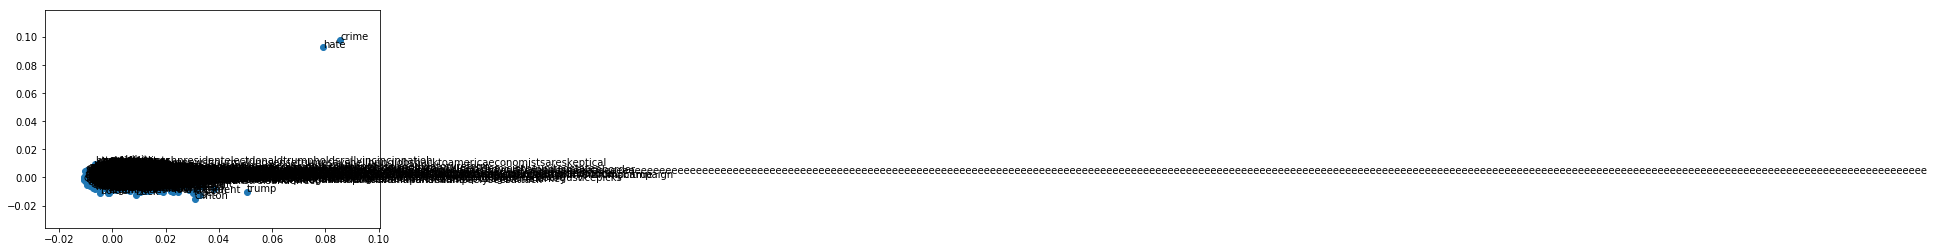

In [323]:
# TODO: design & train model

# train Word2Vec model

w2v_model = Word2Vec(docs, min_count=1)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


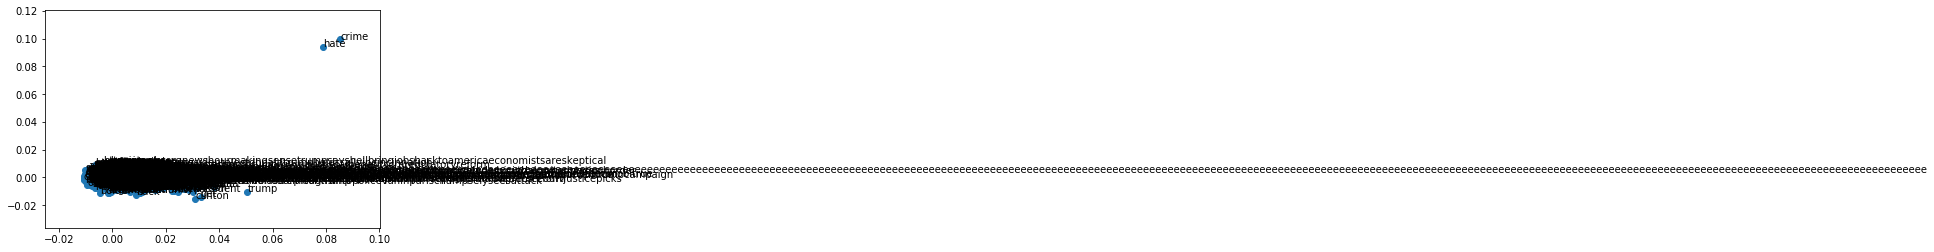

In [324]:
# fit PCA 2d projection to vectors

vector_vocab = w2v_model[w2v_model.wv.vocab]

pca_model = PCA(n_components=2)

pca2d_projection = pca_model.fit_transform(vector_vocab)

# scatterplot the projection

pyplot.scatter(pca2d_projection[:, 0], pca2d_projection[:, 1])

vocab = list(w2v_model.wv.vocab)

for i, word in enumerate(vocab):
    
    pyplot.annotate(word, xy=(pca2d_projection[i, 0], pca2d_projection[i, 1]))